# NHANES I Survival Model

This is a cox proportional hazards model on data from <a href="https://wwwn.cdc.gov/nchs/nhanes/nhanes1">NHANES I</a> with followup mortality data from the <a href="https://wwwn.cdc.gov/nchs/nhanes/nhefs">NHANES I Epidemiologic Followup Study</a>. It is designed to illustrate how SHAP values enable the interpretion of XGBoost models with a clarity traditionally only provided by linear models. We see interesting and non-linear patterns in the data, which suggest the potential of this approach. Keep in mind the data has not yet been checked by us for calibrations to current lab tests and so you should not consider the results as actionable medical insights, but rather a proof of concept. 

In [1]:
import matplotlib.pylab as pl
import numpy as np
import xgboost
from sklearn.model_selection import train_test_split

import shap

## Create XGBoost data objects

This uses a pre-processed subset of NHANES I data available in the SHAP datasets module.

In [2]:
X, y = shap.datasets.nhanesi()

# human readable feature values
X_display, y_display = shap.datasets.nhanesi(display=True)

xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)





## Train XGBoost model

In [3]:
params = {"eta": 0.002, "max_depth": 3, "objective": "survival:cox", "subsample": 0.5}
model_train = xgboost.train(params, xgb_train, 10000, evals=[(xgb_test, "test")], verbose_eval=1000)

[0]	test-cox-nloglik:7.67918
[1000]	test-cox-nloglik:7.02985
[2000]	test-cox-nloglik:6.97516
[3000]	test-cox-nloglik:6.96240
[4000]	test-cox-nloglik:6.96217
[5000]	test-cox-nloglik:6.96558
[6000]	test-cox-nloglik:6.96995
[7000]	test-cox-nloglik:6.97310
[8000]	test-cox-nloglik:6.97721
[9000]	test-cox-nloglik:6.98116
[9999]	test-cox-nloglik:6.98511


In [4]:
# train final model on the full data set
params = {"eta": 0.002, "max_depth": 3, "objective": "survival:cox", "subsample": 0.5}
model = xgboost.train(params, xgb_full, 5000, evals=[(xgb_full, "test")], verbose_eval=1000)

[0]	test-cox-nloglik:9.28404
[1000]	test-cox-nloglik:8.60868
[2000]	test-cox-nloglik:8.53134
[3000]	test-cox-nloglik:8.49490
[4000]	test-cox-nloglik:8.47122
[4999]	test-cox-nloglik:8.45328


## Check Performance

The C-statistic measures how well we can order people by their survival time (1.0 is a perfect ordering).

In [5]:
def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels[j] > 0 and abs(labels[i]) > labels[j]:
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches / total


# see how well we can order people by survival
c_statistic_harrell(model_train.predict(xgb_test), y_test)

0.817035332310394

## Explain the model's predictions on the entire dataset

In [6]:
shap_values = shap.TreeExplainer(model).shap_values(X)

### SHAP Summary Plot

The SHAP values for XGBoost explain the margin output of the model, which is the change in log odds of dying for a Cox proportional hazards model. We can see below that the primary risk factor for death according to the model is being old. The next most powerful indicator of death risk is being a man.

This summary plot replaces the typical bar chart of feature importance. It tells which features are most important, and also their range of effects over the dataset. The color allows us to visualize how changes in the value of a feature effect the change in risk (such that a high white blood cell count leads to a high risk of death).

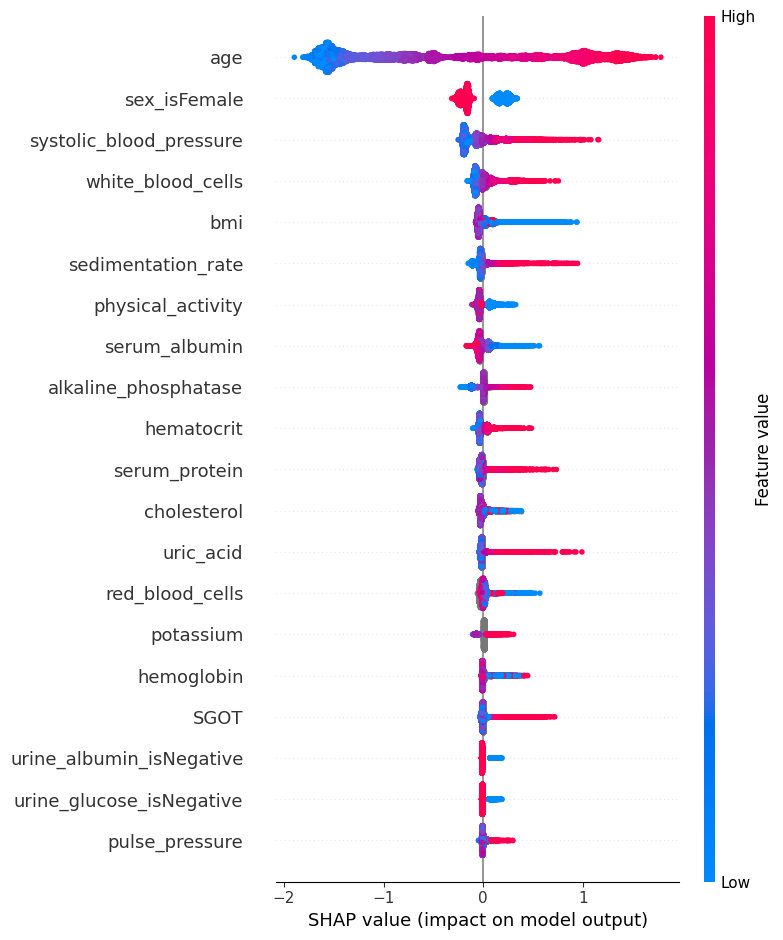

In [7]:
shap.summary_plot(shap_values, X)

### SHAP Dependence Plots

While a SHAP summary plot gives a general overview of each feature, a SHAP dependence plot shows how the model output varies by feature value. Note that every dot is a person, and the vertical dispersion at a single feature value results from interaction effects in the model. The feature used for coloring is automatically chosen to highlight what might be driving these interactions. Later we will see how to check that the interaction is really in the model with SHAP interaction values. Note that the row of a SHAP summary plot results from projecting the points of a SHAP dependence plot onto the y-axis, then recoloring by the feature itself.

Below we give the SHAP dependence plot for each of the NHANES I features, revealing interesting but expected trends. Keep in mind the calibration of some of these values can be different than a modern lab test so be careful drawing conclusions.

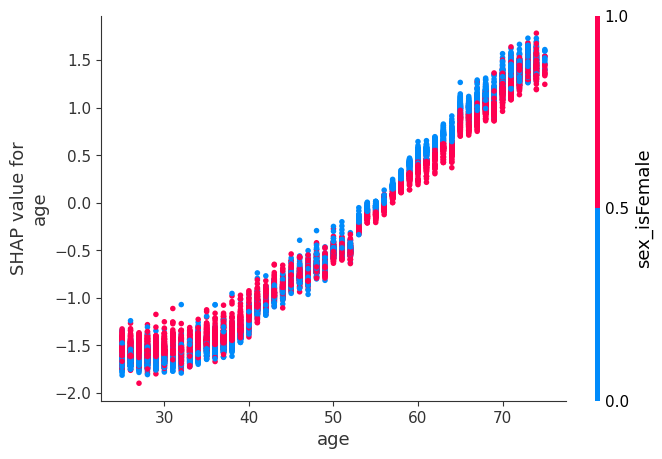

In [8]:
# we pass "age" instead of an index because dependence_plot() will find it in X's column names for us
# Systolic BP was automatically chosen for coloring based on a potential interaction to check that
# the interaction is really in the model see SHAP interaction values below
shap.dependence_plot("age", shap_values, X)

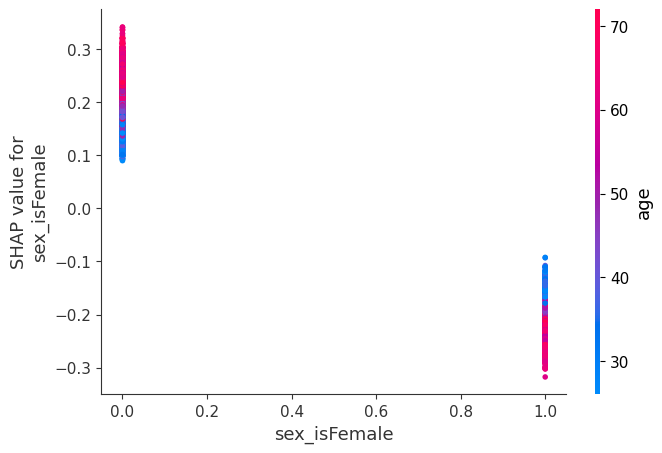

In [9]:
# we pass display_features so we get text display values for sex
shap.dependence_plot("sex_isFemale", shap_values, X, display_features=X_display)

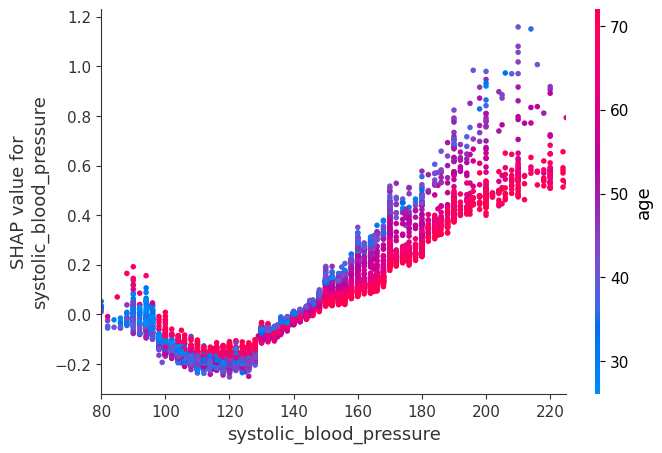

In [10]:
# setting show=False allows us to continue customizing the matplotlib plot before displaying it
shap.dependence_plot("systolic_blood_pressure", shap_values, X, show=False)
pl.xlim(80, 225)
pl.show()

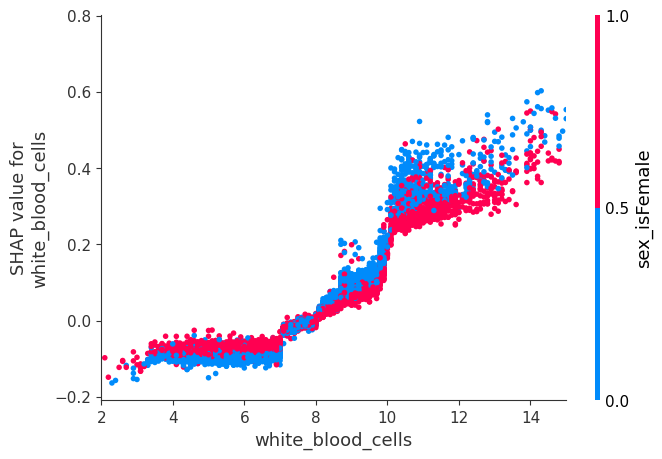

In [11]:
shap.dependence_plot("white_blood_cells", shap_values, X, display_features=X_display, show=False)
pl.xlim(2, 15)
pl.show()

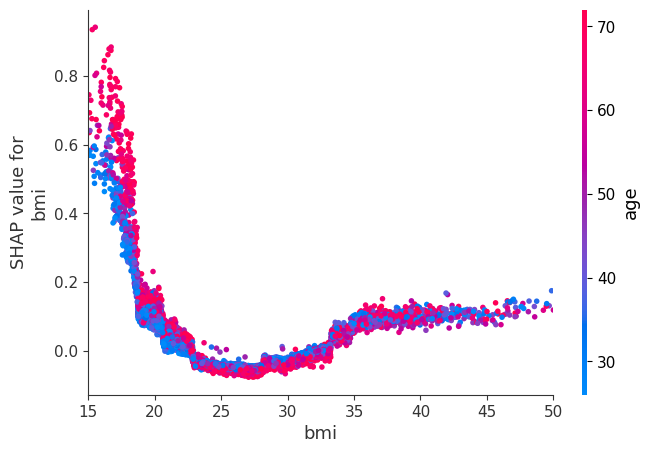

In [12]:
shap.dependence_plot("bmi", shap_values, X, display_features=X_display, show=False)
pl.xlim(15, 50)
pl.show()

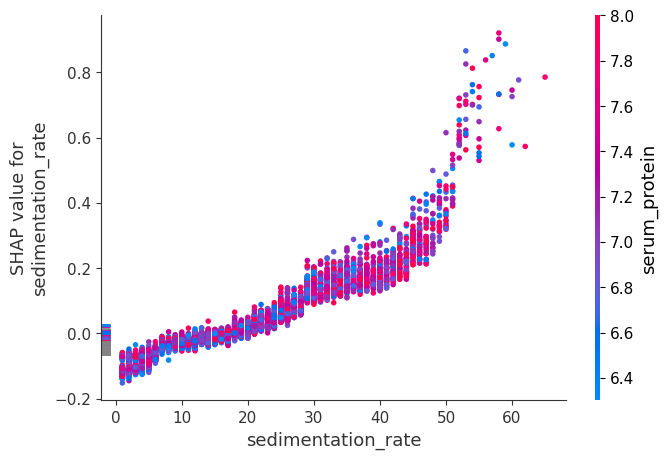

In [13]:
shap.dependence_plot("sedimentation_rate", shap_values, X)

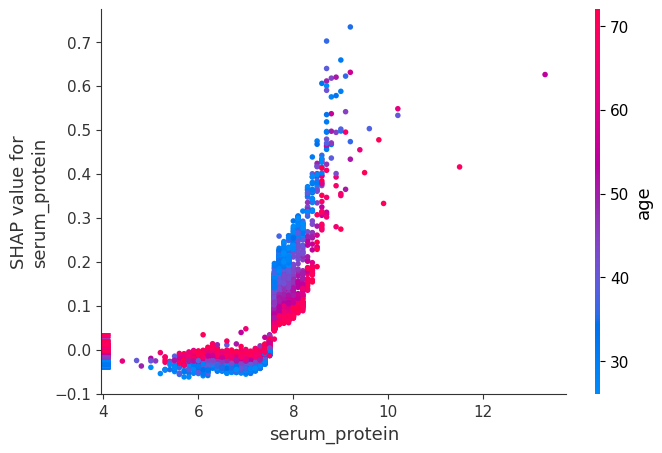

In [14]:
shap.dependence_plot("serum_protein", shap_values, X)

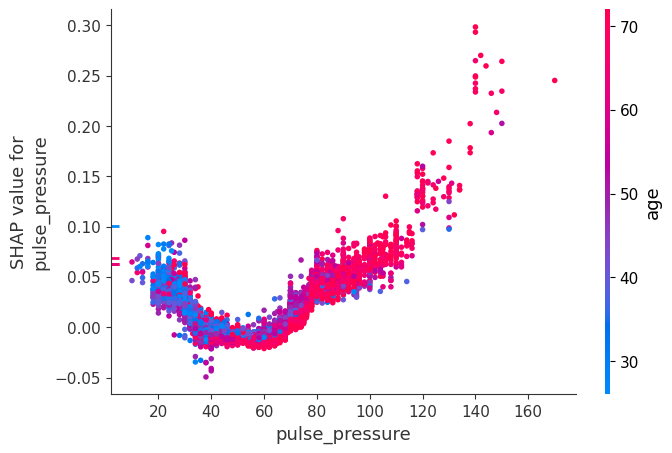

In [15]:
shap.dependence_plot("pulse_pressure", shap_values, X)

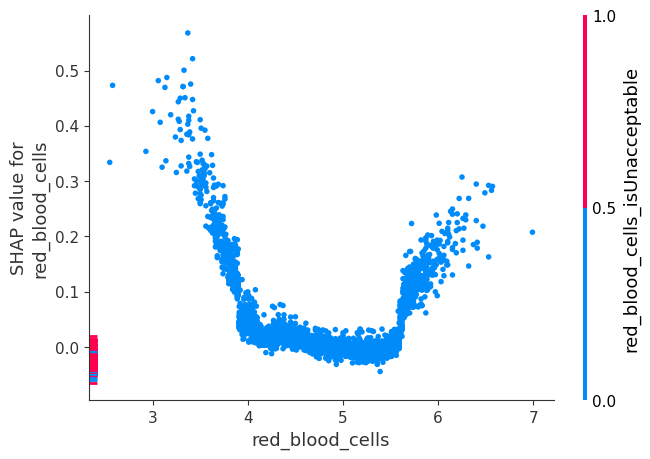

In [16]:
shap.dependence_plot("red_blood_cells", shap_values, X)

## Compute SHAP Interaction Values

See the Tree SHAP paper for more details, but briefly, SHAP interaction values are a generalization of SHAP values to higher order interactions. Fast exact computation of pairwise interactions are implemented in the later versions of XGBoost (>=1.0.0) with the pred_interactions flag. With this flag XGBoost returns a matrix for every prediction, where the main effects are on the diagonal and the interaction effects are off-diagonal. 

The main effects are similar to the SHAP values you would get for a linear model, and the interaction effects capture all the higher-order interactions and divide them up among the pairwise interaction terms. Note that the sum of the entire interaction matrix is the difference between the model's current output and expected output, and so the interaction effects on the off-diagonal are split in half (since there are two of each). 

When plotting interaction effects the SHAP package automatically multiplies the off-diagonal values by two to get the full interaction effect.

In [17]:
# we only take 300 people in order to run quicker
number_patients = 300

shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X.iloc[:number_patients, :])

### SHAP Interaction Value Summary Plot

A summary plot of a SHAP interaction value matrix plots a matrix of summary plots with the main effects on the diagonal and the interaction effects off the diagonal.

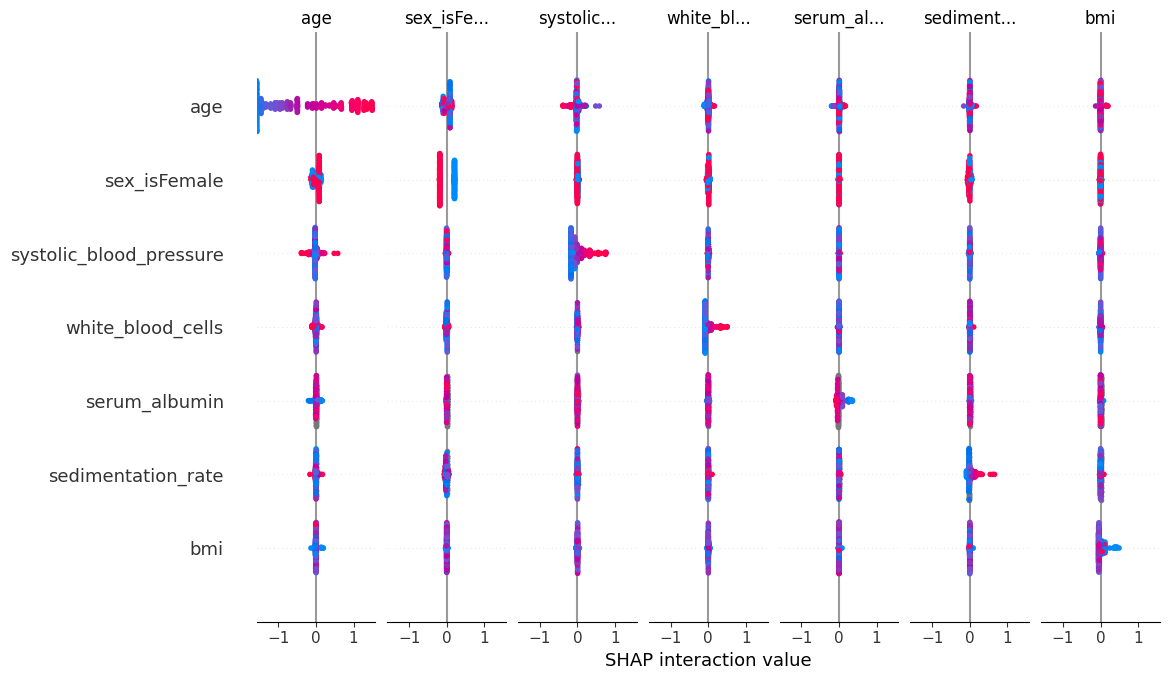

In [18]:
shap.summary_plot(shap_interaction_values, X.iloc[:number_patients, :])

### SHAP Interaction Value Dependence Plots

Running a dependence plot on the SHAP interaction values allows us to separately observe the main effects and the interaction effects.

Below we plot the main effects for age and some of the interaction effects for age. It is informative to compare the main effects plot of age with the earlier SHAP value plot for age. The main effects plot has no vertical dispersion because the interaction effects are all captured in the off-diagonal terms.

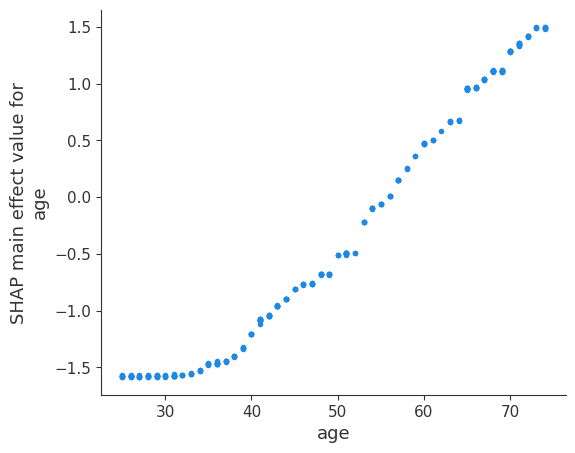

In [19]:
shap.dependence_plot(
    ("age", "age"),
    shap_interaction_values,
    X.iloc[:number_patients, :],
    display_features=X_display.iloc[:number_patients, :],
)

Now we plot the interaction effects involving age. These effects capture all of the vertical dispersion that was present in the original SHAP plot but is missing from the main effects plot above. The plot below involving age and sex shows that the sex-based death risk gap varies by age and peaks at age 60.

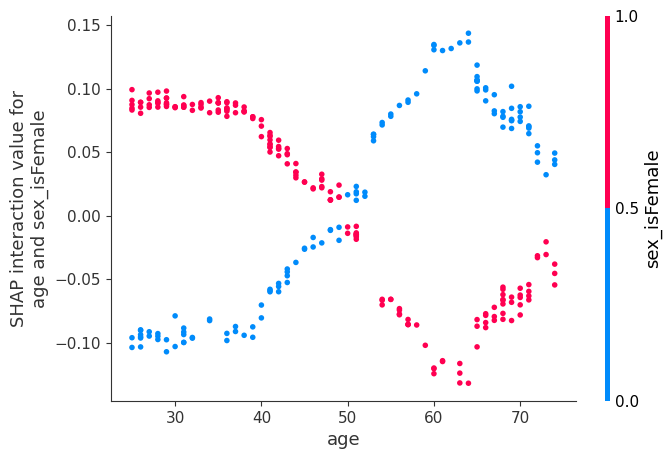

In [20]:
shap.dependence_plot(
    ("age", "sex_isFemale"),
    shap_interaction_values,
    X.iloc[:number_patients, :],
    display_features=X_display.iloc[:number_patients, :],
)

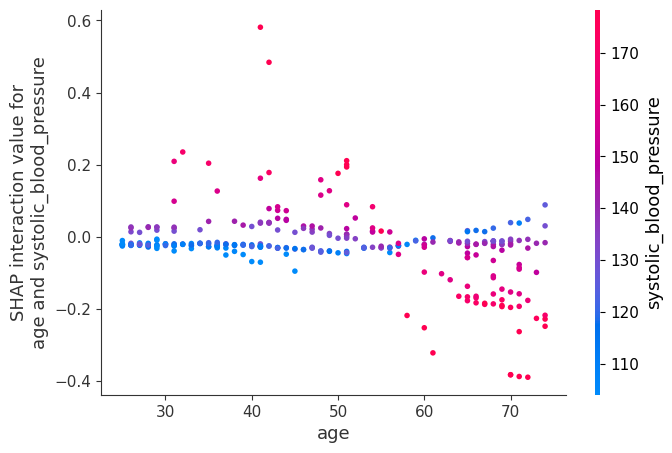

In [21]:
shap.dependence_plot(
    ("age", "systolic_blood_pressure"),
    shap_interaction_values,
    X.iloc[:number_patients, :],
    display_features=X_display.iloc[:number_patients, :],
)

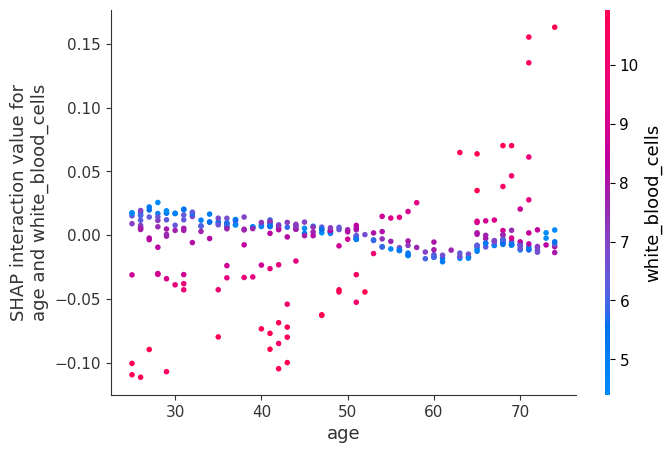

In [22]:
shap.dependence_plot(
    ("age", "white_blood_cells"),
    shap_interaction_values,
    X.iloc[:number_patients, :],
    display_features=X_display.iloc[:number_patients, :],
)

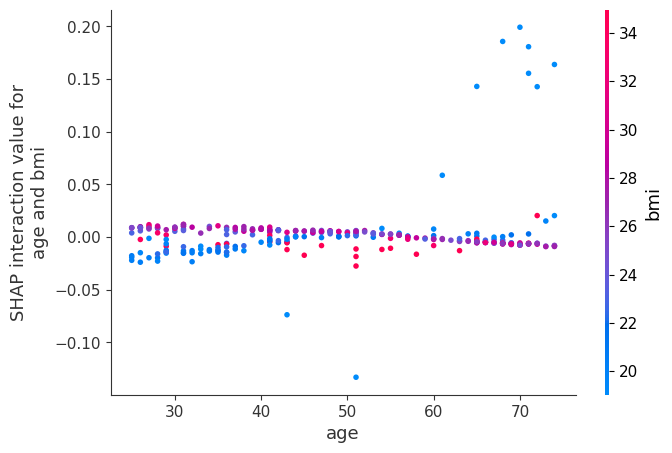

In [23]:
shap.dependence_plot(
    ("age", "bmi"),
    shap_interaction_values,
    X.iloc[:number_patients, :],
    display_features=X_display.iloc[:number_patients, :],
)

Now we show a couple examples with systolic blood pressure.

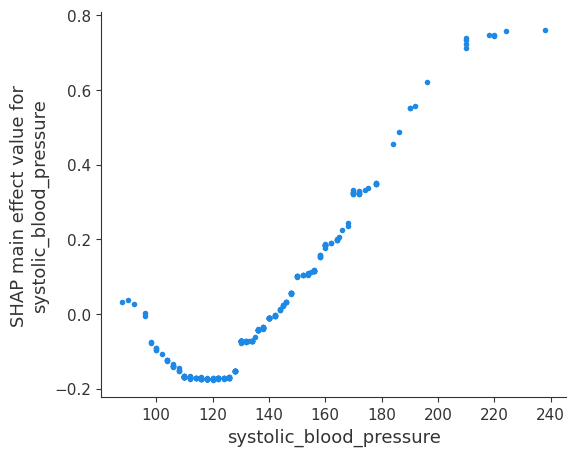

In [24]:
shap.dependence_plot(
    ("systolic_blood_pressure", "systolic_blood_pressure"),
    shap_interaction_values,
    X.iloc[:number_patients, :],
    display_features=X_display.iloc[:number_patients, :],
)

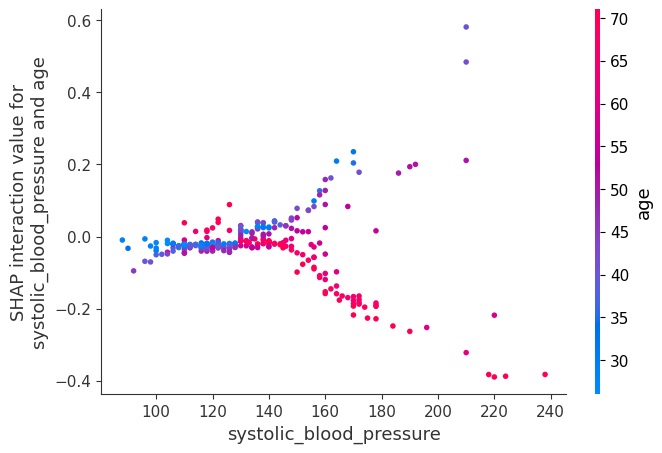

In [25]:
shap.dependence_plot(
    ("systolic_blood_pressure", "age"),
    shap_interaction_values,
    X.iloc[:number_patients, :],
    display_features=X_display.iloc[:number_patients, :],
)

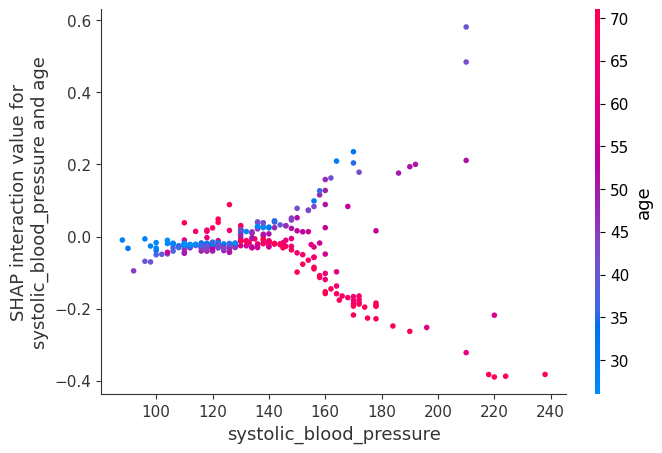

In [26]:
shap.dependence_plot(
    ("systolic_blood_pressure", "age"),
    shap_interaction_values,
    X.iloc[:number_patients, :],
    display_features=X_display.iloc[:number_patients, :],
)

We sum up the interaction over all patients to plot a which features interact the most. Note that we do not analyze how the features interact (high feature A + low feature B leads to outcome C, etc.).
Light colors show strong interaction effects

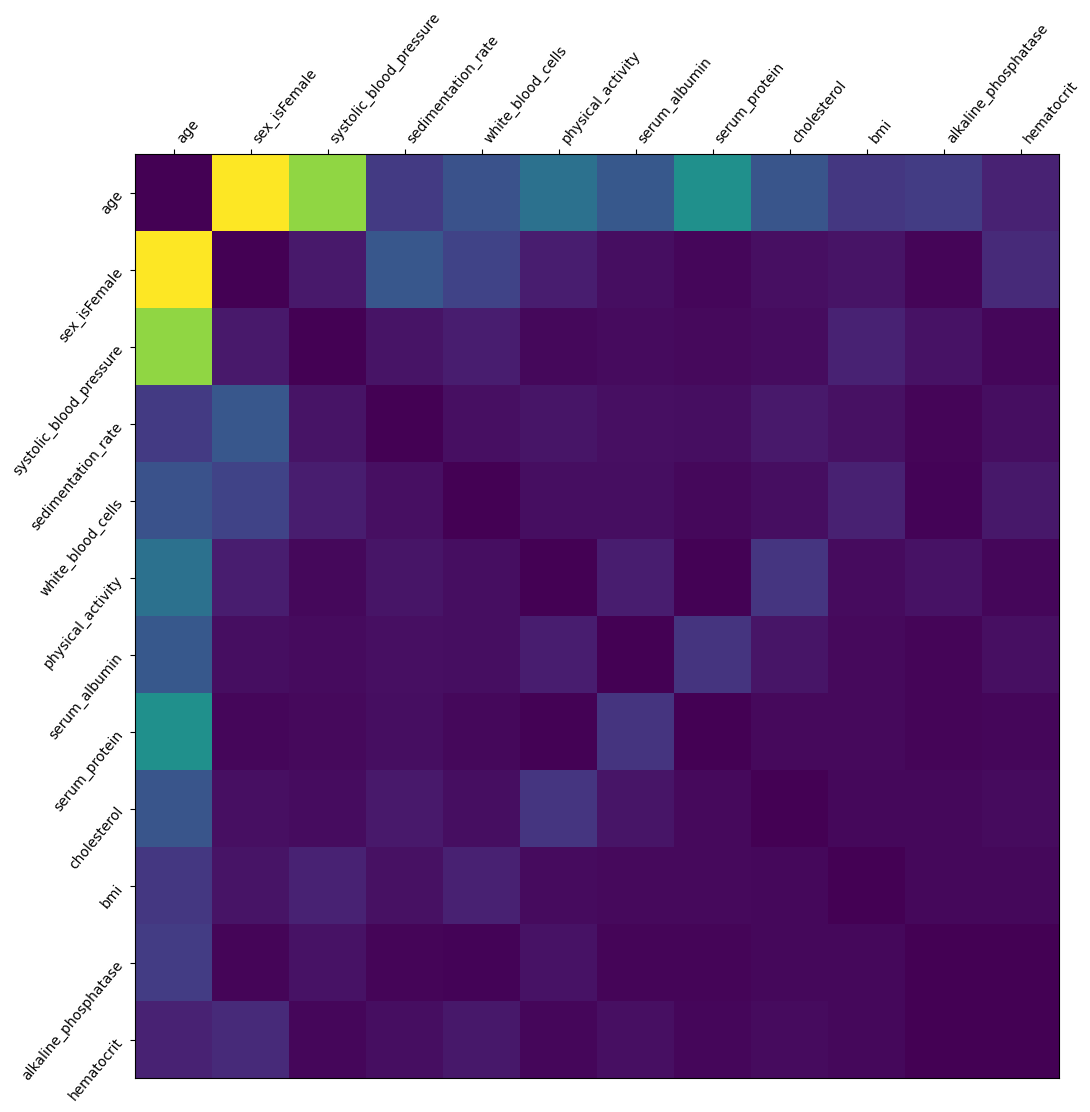

In [27]:
interaction_matrix = np.abs(shap_interaction_values).sum(0)
for i in range(interaction_matrix.shape[0]):
    interaction_matrix[i, i] = 0
inds = np.argsort(-interaction_matrix.sum(0))[:12]
sorted_ia_matrix = interaction_matrix[inds, :][:, inds]
pl.figure(figsize=(12, 12))
pl.imshow(sorted_ia_matrix)
pl.yticks(
    range(sorted_ia_matrix.shape[0]),
    X.columns[inds],
    rotation=50.4,
    horizontalalignment="right",
)
pl.xticks(
    range(sorted_ia_matrix.shape[0]),
    X.columns[inds],
    rotation=50.4,
    horizontalalignment="left",
)
pl.gca().xaxis.tick_top()
pl.show()